# Dephasing noise spectroscopy of qutrits

Assume that a qutrit is surrounded by dephasing noisse and affected by a sequence of pulses.
The effective Hamiltonian of the qutrit would be $H=\sum_{a=0, 1}\beta_{-a}(t)y_{-a}(t)Z^a$; 
where $\beta_{a}(t)$ is the dephasing functions, $y_{a}(t)$ is the switching functing related to the characteristics of the pulse sequence,
and Z is the generalized Pauli operator in d-dimension.

Here we call the necessary packages, and define some fixed parameters.

In [1]:
import matplotlib as m
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
from sympy import *
from sympy import Sum, integrate, symbols, simplify, init_printing
import scipy
#from scipy import integrate
import matplotlib as m
import matplotlib.pyplot as plt
from mpmath import *
mp.dps = 20; mp.pretty = True
import sys
import time
start = time.process_time()

T = 1  # one unit time interval
M = 30 # number of repeating pulse sets
xi = np.round(np.exp(2*np.pi*1j/3),6) 
W = 70 # W = \Omega is the upper experimental measurable limit of /omega
wr = lambda r : 2*np.pi/(T/r)  # wn = w(r) = \omega(r) = r\omega_0 = r.w(1)
N = np.int(W/wr(1)) # number of Alvarez-Suter expreriments in each measurement set
rmax=N
#print(wr(1),rmax, xi)

The symmetric pulse sequence $\{ P_{1,-1}^{-1},P_{1,-1},P_{-1,0}^{-1},P_{-1,0},P_{0,1}^{-1},
P_{0,1} \}$ will be applied to the qutrit on time instances $\{ 0,\frac{t_1 .T}{r},\frac{t_1 .T}{r},\frac{t_2 . T}{r},\frac{t_2 .T}{r},\frac{T}{r} \}$, with corresponding switching functions $\{y_{a}(t \in [0,\frac{t_1 .T}{r})) = 1,\: y_{a}(t \in [\frac{t_1 .T}{r},\frac{t_2 .T}{r}))=\xi^{-a},\:y_{a} (t \in [\frac{t_2 .T}{r},\frac{T}{r})) = \xi^{a}\}$; where $\xi=e^{2\pi i/3}$(=xi), and is repeated for $M$ rounds. 

First some experimental parameters are assigned for the simulation, and then 
the swithcing functions during $[0,T/r]$ ($y_0$ or y0) and $[0,M.T/r]$ (y) is coded according to $F_{a}(\omega,t)= \int_{0}^{t}dt'y_{a}(t')e^{i\omega t'}$ that could be simplified in the form $F_{a}(\omega,t)=\frac{-i}{\omega}\sum_{p=1}^4f_p(a)e^{i\omega t_p}$ where $\{ f_1(a)=-1, f_2(a)=1-\xi^{-a}, f_2(a)=\xi^{-a}-\xi^{a}, f_3(a)= \xi^{a}\}$ and $\{t_1=0, t_2=t_1 T/r, t_2=t_2 T/r, t_3= T/r \}$.

In [2]:
#sys.exit()
def yT(a,t,r):  
    if   0 <= t < T/(7*r):         return 1
    elif T/(7*r) <= t < 2*T/(5*r): return xi**(-a)
    elif 2*T/(5*r) <= t < T/r:     return xi**(a)
def y(a,t,r):
    if   0 <= t < T/r: return yT(a,t,r)
    elif   t >= T/r:   return yT(a,t - floor(t/(T/r))*(T/r),r) 

def fi(i,a):  
    if   i==1:     return -1
    elif i==2:     return 1-xi**(-a)
    elif i==3:     return xi**(-a)-xi**(a)
    elif i==4:     return xi**(a)
t1= 1/7
t2= 2/5
def ti(i,r):  
    if   i==1:     return 0
    elif i==2:     return t1*T/r
    elif i==3:     return t2*T/r
    elif i==4:     return T/r

def Ft(a,w,r):    
    if w==0: return nsum(lambda i: fi(i,a)*ti(i,r),[2,4])
    else: return -(1j)/w*nsum(lambda i: fi(i,a)*exp((1j)*w*ti(i,r)),[1,4])

Farray = np.zeros([2,N,N],dtype=complex)
for a in range(2):
    for k in range(N):
        for r in range(N):
            #print(Ft(a+1,(k)*wr(1),r+1))
            Farray[a][k][r]= Ft(a+1,(k)*wr(1),r+1)

For simplicity of notation, considering $(m_{n^{\prime\prime}},n_{n^{\prime\prime}})=(m,n)$, the nonzero $(p,q)$ indices in $\lambda_{abmn}= 3 O_{mn}V_{\{Mod(a+b-m,3),Mod(-n,3)\}} (1-\xi^{-an})(1-\xi^{-bn}) \xi^{m n}$ would depend on $(a,b,m,n)$ by p=\{Mod(a+b-m,3),q=Mod(-n,3)\}. So the qutrit observables and initial states in four rounds are chosen as $\hat{O_1}=Z^1X^1, \rho_1(0)=Z^1X^2$, $\hat{O_2}=Z^1X^2, \rho_2(0)=Z^2X^1$, $\hat{O_3}=Z^2X^1, \rho_3(0)=Z^2X^2$, and $\hat{O_4}=Z^2X^2, \rho_4(0)=Z^1X^1$, where $V_{p,q}=1$.

Now we code the following functions:

L or $\lambda_{abmn}= 3 O_{mn}V_{\{Mod(a+b-m,3),Mod(-n,3)\}} (1-\xi^{-an})(1-\xi^{-bn}) \xi^{m n}$, where $(m,n)$ indices for each block are different and notes at $(m_0,n_0)=(1,1), (m_1,n_1)=(1,2), (m_2,n_2)=(2,1)$, and $(m_3,n_3)=(2,2)$ (i.e. $(m_{n^{\prime\prime}},n_{n^{\prime\prime}})=(e_{n^{\prime\prime}},f_{n^{\prime\prime}}); n^{\prime\prime}\in \{0,...,3\}$)

In [3]:

import time
start = time.process_time()

def delta(s1,s2): # kronecker delta function (did not find in python)
    if s1==s2: return 1
    else:    return 0
    
def O(m, n, m11):
    if    m11==0: return delta(m,1)*delta(n,1)*0.3
    elif  m11==1: return delta(m,2)*delta(n,2)*0.2
    elif  m11==2: return delta(m,1)*delta(n,2)*0.4
    
def V(m, n, m11):
    if    m11==0: return delta(m,1)*delta(n,2)*1
    elif  m11==1: return delta(m,2)*delta(n,1)*0.7
    elif  m11==2: return delta(m,2)*delta(n,1)*0.6    

def L(a,b,m11):
    if    m11==0: return 3*O(1, 1, m11)*V(fmod((a+b)-1,3),fmod(-1,3), m11)*(1-xi**(-a*1))*(1-xi**(-b*1))*xi**(1*1)
    elif  m11==1: return 3*O(2, 2, m11)*V(fmod((a+b)-2,3),fmod(-2,3), m11)*(1-xi**(-a*2))*(1-xi**(-b*2))*xi**(2*2) 
    elif  m11==2: return 3*O(1, 2, m11)*V(fmod((a+b)-1,3),fmod(-2,3), m11)*(1-xi**(-a*2))*(1-xi**(-b*2))*xi**(1*2) 

# maybe print the matrix form?    
#for m11 in range(3):
#    for a in range(2):
#        for b in range(2):
#              print(L(a+1,b+1,m11))
#sys.exit()

Cf that includes all coefficients of $S_{ab}(\omega)$ in Eq.(1),sec.III.C of manuscript, 

Ci that is a $4\times1$ matrix including $C_{1,...,4}$ coefficients in Eq.(1),sec.III.C of manuscript, and 

$[\textbf{A}]_{4N \times 4N}$, the main coefficient matrix with elements $\textbf{A}_{nm}=\delta_{m'/n',\lfloor m'/n'\rfloor} C_{m^{\prime\prime}}(e_{n^{\prime\prime}},f_{n^{\prime\prime}},m'\omega_0,T/n')$, as in manuscript, that is equivalent to $delta((m')/n',\lfloor (m')/n'\rfloor)*C(mi,ni,w,n'=n1 ,m^{\prime\prime}=m11)$ in this code with following indices. 

$m,n\in\{0,...,4N-1\}$,

$m'=\lfloor \frac{m}{4}\rfloor =P(m,4) \in \{0,...,N-1\}$: appears in $x_i(m'\omega_0)$ and is equivalent to $kn'$, and refers to the coefficient matrix row index,

When we compare the row and coloumn indices of the coefficient matrix in $\delta$ factor, we use $m' \in \{0,...,N-1\}$ to be consistent with $n' \in \{1,...,N\}$.

$m^{\prime\prime}= Mod(m,4)=Q(m,4) \in \{0,...,3\}$: represents four unknown functions $x_i$, 

$n'= Mod(n,N)+1 = Q(n,N)+1 \in \{1,...,N\}$: represents $r$ appearing in $T/r$ (its maximum value is chosen to yield a square coefficient matrix $\textbf{A}$), 

%%%%Remembering that whenever we refer to the coefficient matrix coloumn index, we have $n'-1 \in \{0,...,N-1\}$

$n^{\prime\prime}=\lfloor \frac{n}{N} \rfloor=P(n,N) \in \{0,...,3\}$: represents four blocks or sets of experiments with different fixed indices (m,n). 

In [4]:
def Cf(a,b,w,r,m11):
    return L(a,b,m11)*Ft(a,w,r)*conj(Ft(-b,w,r))
    #return F(a,w,r,1)*np.conjugate(F(-b,w,r,1))
#print(Cf(1,1, 1,1, 2*wr(1), 1))
#sys.exit()   
def C(m11, k, r, p):   # alpha = 2**(1-delta(m1*wr(1),0))
    if   p==0: return           (Cf(1,1,k*wr(1), r,m11)  + Cf(-1,-1,k*wr(1), r,m11))
    elif p==1: return     (1j)* (Cf(1,1,k*wr(1), r,m11)  - Cf(-1,-1,k*wr(1), r,m11))
    elif p==2: return           (Cf(1,-1,k*wr(1), r,m11) + Cf(-1,1,k*wr(1), r,m11)) 

    
#for p in range(3):
#    for m11 in range(3):
#        for k in range(N):
#            for r in range(N):
#                print(C(k, r+1, p, m11))

P = lambda s,smax : np.int(s/smax)         
Q = lambda s,smax : np.remainder(s,smax)   
A = np.zeros([3*N,3*N], dtype=complex)   # m,n = {0,1,...,4(N)-1}      
for n0 in range(3*N):                    
    for m0 in range(3*N):
        if delta((P(m0,3))/(Q(n0,N)+1),floor((P(m0,3))/(Q(n0,N)+1)))!= 0: 
                A[n0][m0] = (0.5**(delta(P(m0,3),0)))*M*wr(Q(n0,N)+1) * C(P(n0,N), P(m0,3), Q(n0,N)+1, Q(m0,3))
                #print(time.process_time() - start)
                #print(n0,Q(n0,N)+1,P(n0,N), m0, P(m0,4), Q(m0,4),M*wr(Q(n0,N)+1),\
                     # C(Indx[P(n0,N)][0], Indx[P(n0,N)][1], P(m0,4), Q(n0,N)+1, Q(m0,4)))
                    # 0.5**(delta(P(m0,3),1))*


Here are the preassumed noise spectra as:

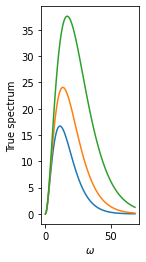

In [11]:
def spect(g,w):
    return  w**2*exp(-g*w)

#def Odd(w):
#    if w >= 0: return  10/(np.abs(w)+1)
#    elif w<0:  return  -10/(np.abs(w)+1)  #np.sign(w) returnning zero at w=0. HOWEVER, Odd(w) is not working due to error: true value is ambigious
#print(Odd(0),Odd(1*wr(1)),Odd(2*wr(1)))  

spectlist1  = np.zeros([N,1])
spectlist2  = np.zeros([N,1])
spectlist3  = np.zeros([N,1])
for i in range(N):
    spectlist1[i]=spect(0.18,i*wr(1))
    spectlist2[i]=spect(0.15,i*wr(1))
    spectlist3[i]=spect(0.12,i*wr(1))
       
w1 = wr(1)*np.arange(0, N, 0.1)

def spectList1():
    list = []
    for i in range(len(w1)):
        list.append(spect(0.18,w1[i]))
    return list
specvec1 = spectList1()
def spectList2():
    list = []
    for i in range(len(w1)):
        list.append(spect(0.15,w1[i]))
    return list
specvec2 = spectList2()
def spectList3():
    list = []
    for i in range(len(w1)):
        list.append(spect(0.12,w1[i]))
    return list
specvec3 = spectList3()


plt.subplot(131)
plt.plot(w1,specvec1,w1,specvec2,w1,specvec3)
plt.xlabel('$\omega$')
plt.ylabel('True spectrum')
plt.show()

The above code indicates that the simplified analytical expression of filter functions $F_{a}(\omega,cyT/r)$ corresponding the switching functions $\{y_{a}(0 \le t < t_1) = 1,\: y_{a}(t_1 \le t < t_2)=\xi^{-a},\:y_{a} (t_2 \le t < t_3) = \xi^{a}\}$; $\xi=e^{2\pi i/3}$(=xi) would be 

$F_{a}(\omega,cyT/r)$= $\int_{0}^{T/r}dt'y_{a}(t')e^{i\omega t'}$ + $\int_{T/r}^{2 T/r}dt'y_{a}(t')e^{i\omega t'}$+... + $\int_{(cy-1)T/r}^{cy T/r}dt'y_{a}(t')e^{i\omega t'} $= $cy\int_{0}^{T/r}dt'y_{a}(t')e^{i\omega t'} $=
$\Big[
\frac{-i\: cy}{\omega} \Big(-1 + (1-\xi^{-a})e^{i\omega t_1} + (\xi^{-a}-\xi^{a})e^{i\omega t_2} + \xi^{a}e^{i\omega t_3} \Big);\: (w\ne 0),\: cy\Big((1-\xi^{-a})t_1 + (\xi^{-a}-\xi^{a})t_2 + \xi^{a}t_3 \Big);\: (w= 0) 
\Big]$, where $cy=\{1,....,M\}$, that is $F_{a}(\omega,cyT/r)= 
\Big[ 
\frac{-i\:cy}{\omega} \sum_{n=0}^3 h_n(a) e^{i\omega t_n};(w\ne 0)$,
$\Big(h_0(a)=-1, h_1(a)=(1-\xi^{-a}), h_2(a)=(\xi^{-a}-\xi^{a}), h_3(a)=\xi^{a}\Big)$,
$cy \sum_{n=0}^3 g_n(a)t_n;\:(w = 0)$,
$\Big(g_0(a)=0, g_1(a)=1-\xi^{-a}, g_2(a)=(\xi^{-a}-\xi^{a}), g_3(a)=\xi^{a}\Big)$, where
$\Big(t_0 = 0, t_1=\frac{T}{7r}$, $t_2=\frac{2T}{3r}$, $t_3=\frac{T}{r}\Big)$
$\Big]$

In the following the functions $h_i(a)$\{=h(i,a)\}, $g_i(a)$\{=g(i,a)\}, and $t_i${=t(i,r)\} are coded.

To more efficiently find the integral coefficients of Eq.1, we simpliy the terms including $I = \int_{0}^{\Omega}d\omega F_a(\omega,cyT/r)F^*_{-b}(\omega,cyT/r)x_i(\omega)$ as $(\omega \ne 0)\:: I = cy^2\sum_{x,y=0}^3 h_x(a)h^*_y(-b)\int_{0.000001}^{\Omega}d\omega\frac{-1}{\omega^2}x_i(\omega)e^{i\omega(t_x(r)-t_y(r))}$

In [12]:
def Cg(a,b,r,m11,g):
    result = L(a,b,m11)*nsum(lambda i1,i2,p,q: fi(i1,a)*fi(i2,b)   \
                             /(-g + (1j)*((ti(i1,r) - ti(i2,r)) + T/r*(p-q)))  \
                             *(-1 + exp(W*(-g + (1j)*((ti(i1,r) - ti(i2,r)) + T/r*(p-q)))))
                               ,[1,4],[1,4],[0,M-1],[0,M-1])
    return result
#for m11 in range(3):
#    for r in range(N):
#        for a in range(2):
#            for b in range(2):
#                    print(Cg(a+1,b+1,r+1,m11,0.09))


def Ce(m11,r):
    return       (Cg(1,1,r,m11,0.18)  + Cg(-1,-1,r,m11,0.18)) \
          +(1j)* (Cg(1,1,r,m11,0.15)  - Cg(-1,-1,r,m11,0.15)) \
          +      Cg(1,-1,r,m11,0.12)  + Cg(-1,1,r,m11,0.12) 



P = lambda s,smax : np.int((s)/smax)           # m'= P(m,4)  = {0,1,...,N-1} , n"= P(n,N)= {0,...,3}
Q = lambda s,smax : np.remainder((s), smax) # n'= Q(n,N)+1 = {1,...,N}     , m"= Q(m,4)= {0,...,3}
#P = lambda s,smax : np.int((s-1)/smax)+1            # m'= P(m,4)  = {0,1,...,N-1} , n"= P(n,N)= {0,...,3}
#Q = lambda s,smax : np.remainder((s-1), smax) + 1 # n'= Q(n,N)+1 = {1,...,N}     , m"= Q(m,4)= {0,...,3}
b = np.zeros([3*N], dtype=complex) # This list includes the simulated experimental expectation values found by exact integral terms (excluding constant term $\eta$)
for n in range(3*N):
    #a1=Indx[P(n,(N))][0]  # n"=P(n,N)
    #a2=Indx[P(n,(N))][1]   
    m11 = P(n,N)  # block no.
    r1 = Q(n,N)+1     # n'=Q(n,N),
    #print(time.process_time() - start1)
    #print(m11,r1)
    #print(F(1,2,a3,M),Cg(1,1,a1,a2,a3,M))
    b[n] = Ce(m11,r1)
    #print(b[n])
 

In [15]:
###################################################################
#print(np.shape(A),np.shape(b))
##################################################

#print(np.shape(A),np.shape(b))
x = np.linalg.lstsq(A,b)
#print(x,np.shape(x))

C:\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [16]:
#print(np.round(x[0],4))
#print(np.real(x[0]))
result = np.real(x[0])
print(result)

[ 1.80069703  1.93761752  5.67069167 13.19886144 13.92187798 17.29411194
 16.64280231 22.79308413 33.55558232 12.0854692  20.14615185 35.65188949
  6.98997694 13.93294108 29.64931054  3.57214046  8.37773852 21.62661751
  1.67634111  4.58720467 14.11253074  0.762078    2.30592976  8.66129881
  0.33751366  1.05635316  4.9173907   0.1436827   0.42251678  2.50473323
  0.05175585  0.12964479  1.02008335]


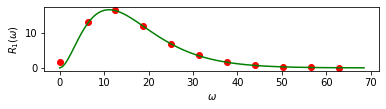

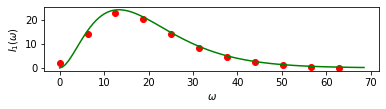

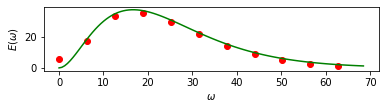

In [23]:
R1 = np.zeros([(N)]) #x1
I1 = np.zeros([(N)]) #x2
E  = np.zeros([(N)]) #x3
#x4 = np.zeros([(N)])

#print(x[0])
#print(x[3][1],x1,x2)
result = np.real(x[0])

R1 = []
I1 = []
E  = []
for n in range(0, 3*N,3):
    R1.append(result[n+0])
    I1.append(result[n+1])
    E.append(result[n+2])

#print(R1)

omega = []
for n in range((N)):
    omega.append(n*wr(1))
    
#print(omega,spectList1)    
##################################################
plt.figure(1)

plt.subplot(311)
#plt.semilogy(omega, x1 ,'ro', omega, Oddlist, 'g^')
plt.plot(omega, R1 ,'ro', w1, specvec1,'g',omega, I1 ,'ro', w1, specvec2, 'g',omega, E ,'ro', w1, specvec3, 'g') 
plt.xlabel('$\omega$')
plt.ylabel('$R_1(\omega$)')
plt.show()

plt.subplot(312)
plt.plot(omega, I1 ,'ro', w1, specvec2, 'g')
plt.xlabel('$\omega$')
plt.ylabel('$I_1(\omega)$')
plt.show()

plt.subplot(313)
plt.plot(omega, E ,'ro', w1, specvec3, 'g')
plt.xlabel('$\omega$')
plt.ylabel('$E(\omega)$')
plt.show()
